In [1]:
# install packages
!pip install seaborn
!pip install torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html
!pip install PyYAML
!pip install imageio
!pip install colorama
# import packages
import os, gc
import zarr
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import l5kit
from tqdm import tqdm
from typing import Dict
from collections import Counter
from prettytable import PrettyTable


#level5 toolkit
from l5kit.data import PERCEPTION_LABELS
from l5kit.dataset import EgoDataset, AgentDataset
from l5kit.data import ChunkedDataset, LocalDataManager

# level5 toolkit 
from l5kit.configs import load_config_data
from l5kit.geometry import transform_points
from l5kit.rasterization import build_rasterizer
from l5kit.visualization import draw_trajectory, draw_reference_trajectory, TARGET_POINTS_COLOR
from l5kit.evaluation import write_pred_csv, compute_metrics_csv, read_gt_csv, create_chopped_dataset

# visualization
from matplotlib import animation
from colorama import Fore, Back, Style

# deep learning
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.models.resnet import resnet18, resnet50, resnet34



Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [2]:
# check files in directory
print((os.listdir('../../../../Dataset')))

plt.rc('animation', html='jshtml')

%matplotlib inline

['lyft_config_files', 'scenes', 'single_mode_sample_submission.csv', 'aerial_map', 'multi_mode_sample_submission.csv', 'archive.zip', 'semantic_map', 'lyft-motion-prediction-autonomous-vehicles.zip', 'meta.json']


In [3]:
# animation for scene
def animate_solution(images):

    def animate(i):
        im.set_data(images[i])
 
    fig, ax = plt.subplots()
    im = ax.imshow(images[0])
    
    return animation.FuncAnimation(fig, animate, frames=len(images), interval=80)

In [4]:
my_arr = np.zeros(3, dtype=[("color", (np.uint8, 3)), ("label", np.bool)])

print(my_arr[0])

([0, 0, 0], False)


In [5]:
my_arr[0]["color"] = [0, 218, 130]
my_arr[0]["label"] = True
my_arr[1]["color"] = [245, 59, 255]
my_arr[1]["label"] = True
my_arr[1]["color"] = [7, 6, 97]
my_arr[1]["label"] = True

print(my_arr)

[([  0, 218, 130],  True) ([  7,   6,  97],  True)
 ([  0,   0,   0], False)]


In [6]:
train = zarr.open("../../../../Dataset/scenes/train.zarr")
validation = zarr.open("../../../../Dataset/scenes/validate.zarr")
test = zarr.open("../../../../Dataset/scenes/test.zarr/")
train.info

Name,/
Type,zarr.hierarchy.Group
Read-only,False
Store type,zarr.storage.DirectoryStore
No. members,5
No. arrays,4
No. groups,1
Arrays,"agents, frames, scenes, traffic_light_faces"
Groups,agents_mask


In [7]:
print(f'We have {len(train.agents)} agents, {len(train.scenes)} scenes, {len(train.frames)} frames and {len(train.traffic_light_faces)} traffic light faces in train.zarr.')
print(f'We have {len(validation.agents)} agents, {len(validation.scenes)} scenes, {len(validation.frames)} frames and {len(validation.traffic_light_faces)} traffic light faces in validation.zarr.')
print(f'We have {len(test.agents)} agents, {len(test.scenes)} scenes, {len(test.frames)} frames and {len(test.traffic_light_faces)} traffic light faces in test.zarr.')

We have 320124624 agents, 16265 scenes, 4039527 frames and 38735988 traffic light faces in train.zarr.
We have 312617887 agents, 16220 scenes, 4030296 frames and 29277930 traffic light faces in validation.zarr.
We have 88594921 agents, 11314 scenes, 1131400 frames and 7854144 traffic light faces in test.zarr.


In [8]:
# set env variable for data
os.environ["L5KIT_DATA_FOLDER"] = "../../../../Dataset"

# get configuration yaml
cfg = load_config_data("../../../../Dataset/lyft_config_files/visualisation_config.yaml")
print(cfg)

{'format_version': 4, 'model_params': {'model_architecture': 'resnet50', 'history_num_frames': 0, 'history_step_size': 1, 'history_delta_time': 0.1, 'future_num_frames': 50, 'future_step_size': 1, 'future_delta_time': 0.1}, 'raster_params': {'raster_size': [224, 224], 'pixel_size': [0.5, 0.5], 'ego_center': [0.25, 0.5], 'map_type': 'py_semantic', 'satellite_map_key': 'aerial_map/aerial_map.png', 'semantic_map_key': 'semantic_map/semantic_map.pb', 'dataset_meta_key': 'meta.json', 'filter_agents_threshold': 0.5}, 'val_data_loader': {'key': 'scenes/sample.zarr', 'batch_size': 12, 'shuffle': False, 'num_workers': 16}}


## Let's make our own config file!

In [9]:
# Raster Parameters
print(f'current raster_param:\n')
for k,v in cfg["raster_params"].items():
    print(f"{k}:{v}")

current raster_param:

raster_size:[224, 224]
pixel_size:[0.5, 0.5]
ego_center:[0.25, 0.5]
map_type:py_semantic
satellite_map_key:aerial_map/aerial_map.png
semantic_map_key:semantic_map/semantic_map.pb
dataset_meta_key:meta.json
filter_agents_threshold:0.5


## Load the data

In [10]:
dm = LocalDataManager()
dataset_path = dm.require(cfg["val_data_loader"]["key"])
zarr_dataset = ChunkedDataset(dataset_path)
zarr_dataset.open()
print(zarr_dataset)

+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|    100     |   24838    |  1893736   |     316008    |       0.69      |        248.38        |        76.24         |        24.83         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


In [11]:
print(dataset_path)

../../../../Dataset/scenes/sample.zarr


/home/amongstar/my_project_env/miniconda3/l5kit/dataset/ego.py:138: RuntimeWarning: disable_traffic_light_faces not found in config, this will raise an error in the future
  return self.get_frame(scene_index, state_index)


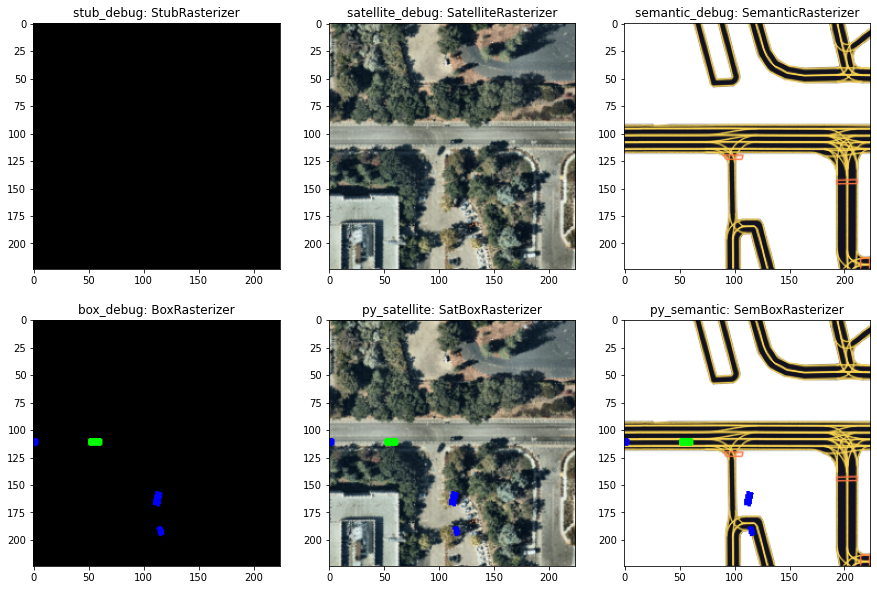

In [11]:
sns.set_style({'axes.grid': False})

def visualize_rgb_image(dataset, index, title="", ax=None):
    """Visualizes Rasterizer's RGB image"""
    data = dataset[index]
    im = data["image"].transpose(1, 2, 0)
    im = dataset.rasterizer.to_rgb(im)

    if ax is None:
        fig, ax = plt.subplots()
    if title:
        ax.set_title(title)
    ax.imshow(im[::-1])
# Prepare all rasterizer and EgoDataset for each rasterizer
rasterizer_dict = {}
dataset_dict = {}

rasterizer_type_list = ["py_satellite", "satellite_debug", "py_semantic", "semantic_debug", "box_debug", "stub_debug"]

for i, key in enumerate(rasterizer_type_list):
    # print("key", key)
    cfg["raster_params"]["map_type"] = key
    rasterizer_dict[key] = build_rasterizer(cfg, dm)
    dataset_dict[key] = EgoDataset(cfg, zarr_dataset, rasterizer_dict[key])
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()
for i, key in enumerate(["stub_debug", "satellite_debug", "semantic_debug", "box_debug", "py_satellite", "py_semantic"]):
    visualize_rgb_image(dataset_dict[key], index=0, title=f"{key}: {type(rasterizer_dict[key]).__name__}", ax=axes[i])
fig.show()

## Configuratuion for Training

In [12]:
DEBUG = True

# training cfg
training_cfg = {
    
    'format_version': 4,
    
     ## Model options
    'model_params': {
        'model_architecture': 'resnet34',
        'history_num_frames': 10,
        'history_step_size': 1,
        'history_delta_time': 0.1,
        'future_num_frames': 50,
        'future_step_size': 1,
        'future_delta_time': 0.1,
    },

    ## Input raster parameters
    'raster_params': {
        
        'raster_size': [224, 224], # raster's spatial resolution [meters per pixel]: the size in the real world one pixel corresponds to.
        'pixel_size': [0.5, 0.5], # From 0 to 1 per axis, [0.5,0.5] would show the ego centered in the image.
        'ego_center': [0.25, 0.5],
        'map_type': "py_semantic",
        
        # the keys are relative to the dataset environment variable
        'satellite_map_key': "aerial_map/aerial_map.png",
        'semantic_map_key': "semantic_map/semantic_map.pb",
        'dataset_meta_key': "meta.json",

        # e.g. 0.0 include every obstacle, 0.5 show those obstacles with >0.5 probability of being
        # one of the classes we care about (cars, bikes, peds, etc.), >=1.0 filter all other agents.
        'filter_agents_threshold': 0.5
    },

    ## Data loader options
    'train_data_loader': {
        'key': "scenes/train.zarr",
        'batch_size': 12,
        'shuffle': True,
        'num_workers': 4
    },

    ## Train params
    'train_params': {
        'checkpoint_every_n_steps': 5000,
        'max_num_steps': 100 if DEBUG else 10000
    }
}

# inference cfg
inference_cfg = {
    
    'format_version': 4,
    'model_params': {
        'history_num_frames': 10,
        'history_step_size': 1,
        'history_delta_time': 0.1,
        'future_num_frames': 50,
        'future_step_size': 1,
        'future_delta_time': 0.1
    },
    
    'raster_params': {
        'raster_size': [300, 300],
        'pixel_size': [0.5, 0.5],
        'ego_center': [0.25, 0.5],
        'map_type': 'py_semantic',
        'satellite_map_key': 'aerial_map/aerial_map.png',
        'semantic_map_key': 'semantic_map/semantic_map.pb',
        'dataset_meta_key': 'meta.json',
        'filter_agents_threshold': 0.5
    },
    
        'test_data_loader': {
        'key': 'scenes/test.zarr',
        'batch_size': 8,
        'shuffle': False,
        'num_workers': 4
    }

}

## Begin Loading Sample Training Data

In [13]:
# root directory
DIR_INPUT = "../../../../Dataset"

#submission
SINGLE_MODE_SUBMISSION = f"{DIR_INPUT}/single_mode_sample_submission.csv"
MULTI_MODE_SUBMISSION = f"{DIR_INPUT}/multi_mode_sample_submission.csv"

# set env variable for data
os.environ["L5KIT_DATA_FOLDER"] = DIR_INPUT
dm = LocalDataManager(None)
print(training_cfg)

{'format_version': 4, 'model_params': {'model_architecture': 'resnet34', 'history_num_frames': 10, 'history_step_size': 1, 'history_delta_time': 0.1, 'future_num_frames': 50, 'future_step_size': 1, 'future_delta_time': 0.1}, 'raster_params': {'raster_size': [224, 224], 'pixel_size': [0.5, 0.5], 'ego_center': [0.25, 0.5], 'map_type': 'py_semantic', 'satellite_map_key': 'aerial_map/aerial_map.png', 'semantic_map_key': 'semantic_map/semantic_map.pb', 'dataset_meta_key': 'meta.json', 'filter_agents_threshold': 0.5}, 'train_data_loader': {'key': 'scenes/train.zarr', 'batch_size': 12, 'shuffle': True, 'num_workers': 4}, 'train_params': {'checkpoint_every_n_steps': 5000, 'max_num_steps': 100}}


In [14]:
# training cfg
train_cfg = training_cfg["train_data_loader"]

# rasterizer
rasterizer = build_rasterizer(training_cfg, dm)

# dataloader
train_zarr = ChunkedDataset(dm.require(train_cfg["key"])).open()
train_dataset = AgentDataset(training_cfg, train_zarr, rasterizer)
train_dataloader = DataLoader(train_dataset, shuffle=train_cfg["shuffle"], batch_size=train_cfg["batch_size"], 
                             num_workers=train_cfg["num_workers"])
print(train_dataset)

MemoryError: Unable to allocate 2.39 GiB for an array with shape (320124624, 2) and data type uint32